# Complete function

In [3]:
import nltk
from PyPDF2 import PdfReader
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import gensim.downloader as api

# Download necessary resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Global variables
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
word_vectors = api.load('glove-wiki-gigaword-100')  # Pre-trained word embeddings


def preprocess_text(text):
    """
    Tokenizes, removes stopwords, and lemmatizes the text.
    """
    tokens = word_tokenize(text.lower())
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token.isalpha() and token not in stop_words]
    return tokens


def read_pdf_and_extract_text(file_path):
    """
    Reads text from a PDF file and returns it as a string.
    """
    reader = PdfReader(file_path)
    text = ""
    for page in reader.pages:
        text += page.extract_text() + " "
    return text.strip()


def preprocess_pdf_text(file_path):
    """
    Reads and preprocesses text from a PDF.
    """
    raw_text = read_pdf_and_extract_text(file_path)
    sentences = sent_tokenize(raw_text)
    preprocessed_sentences = [' '.join(preprocess_text(sentence)) for sentence in sentences]
    return preprocessed_sentences


def create_tfidf_matrix(text_data):
    """
    Creates a TF-IDF matrix from preprocessed text data.
    """
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(text_data)
    return tfidf_matrix, vectorizer


def perform_lsa(tfidf_matrix, n_topics=25):
    """
    Performs Latent Semantic Analysis (LSA) using Truncated SVD.
    """
    lsa_model = TruncatedSVD(n_components=n_topics, random_state=42)
    lsa_matrix = lsa_model.fit_transform(tfidf_matrix)
    return lsa_model, lsa_matrix


def visualize_topics(lsa_matrix):
    """
    Visualizes topics using PCA and t-SNE.
    """
    # Perform PCA
    lsa_pca = PCA(n_components=3).fit_transform(lsa_matrix)

    # Perform t-SNE
    lsa_tsne = TSNE(n_components=3, random_state=42).fit_transform(lsa_matrix)

    # Plot PCA
    plt.figure(figsize=(8, 6))
    plt.scatter(lsa_pca[:, 0], lsa_pca[:, 1])
    plt.title("LSA Topics (PCA)")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.show()

    # Plot t-SNE
    plt.figure(figsize=(8, 6))
    plt.scatter(lsa_tsne[:, 0], lsa_tsne[:, 1])
    plt.title("LSA Topics (t-SNE)")
    plt.xlabel("t-SNE1")
    plt.ylabel("t-SNE2")
    plt.show()


def calculate_semantic_coherence(terms, word_vectors):
    """
    Calculate semantic coherence of a set of terms using word embeddings.
    """
    valid_terms = [term for term in terms if term in word_vectors]
    if len(valid_terms) < 2:
        return 0
    similarities = []
    for term1, term2 in itertools.combinations(valid_terms, 2):
        try:
            similarity = np.dot(word_vectors[term1], word_vectors[term2]) / (
                np.linalg.norm(word_vectors[term1]) * np.linalg.norm(word_vectors[term2])
            )
            similarities.append(similarity)
        except Exception:
            continue
    return np.mean(similarities) if similarities else 0


def generate_topic_names(lsa_model, feature_names, word_vectors, n_top_words=10):
    """
    Generates topic names using semantic coherence.
    """
    topic_data = []

    for topic_idx, topic in enumerate(lsa_model.components_):
        top_indices = topic.argsort()[:-n_top_words-1:-1]
        top_terms = [feature_names[i] for i in top_indices]
        top_weights = topic[top_indices]

        best_word = None
        best_coherence = -1

        for term in top_terms:
            coherence = calculate_semantic_coherence([term], word_vectors)
            context_terms = [t for t in top_terms if t != term]
            context_coherence = calculate_semantic_coherence([term] + context_terms[:3], word_vectors)
            combined_score = (coherence + context_coherence) / 2

            if combined_score > best_coherence:
                best_coherence = combined_score
                best_word = term

        if best_word is None:
            best_word = top_terms[0]

        topic_dict = {
            'Topic': best_word,
            'Semantic_Coherence': best_coherence,
            **{f'Word_{i+1}': term for i, term in enumerate(top_terms)},
            **{f'Weight_{i+1}': weight for i, weight in enumerate(top_weights)}
        }

        topic_data.append(topic_dict)

    df = pd.DataFrame(topic_data)
    return df


def process_pdf_for_topics(file_path, n_topics=25):
    """
    Full workflow to process a PDF, perform LSA, and generate topic names.
    """
    preprocessed_texts = preprocess_pdf_text(file_path)
    tfidf_matrix, vectorizer = create_tfidf_matrix(preprocessed_texts)
    lsa_model, lsa_matrix = perform_lsa(tfidf_matrix, n_topics=n_topics)
    feature_names = vectorizer.get_feature_names_out()
    topics_df = generate_topic_names(lsa_model, feature_names, word_vectors)
    visualize_topics(lsa_matrix)
    return topics_df



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\divya\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\divya\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\divya\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Pygmalion by George Bernard Shaw

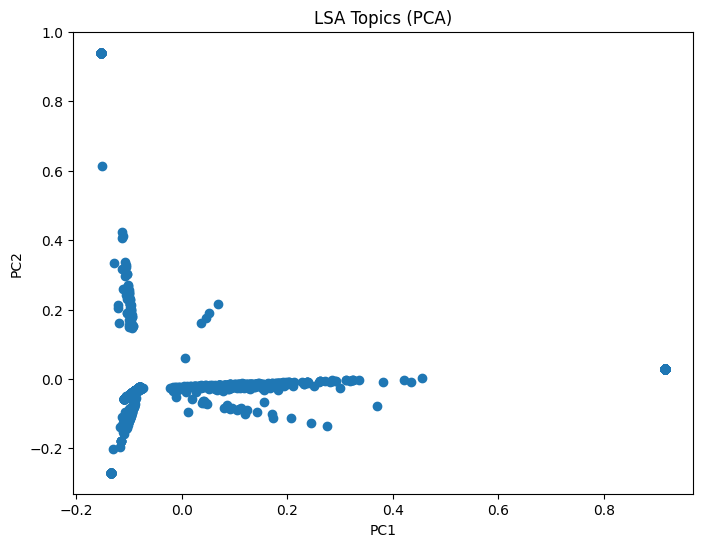

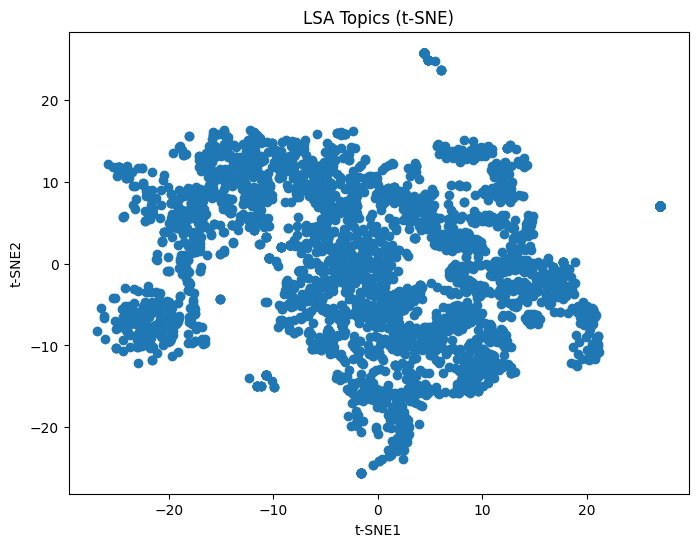

        Topic  Semantic_Coherence     Word_1     Word_2     Word_3     Word_4  \
0       henry            0.129915    higgins  pickering         oh     rising   
1  whimpering            0.084087       liza  pickering  doolittle     rising   
2      return            0.108904  pickering    colonel       come  doolittle   
3         say            0.124400  doolittle       miss   governor     pearce   
4        know            0.161258     pearce      right       girl         go   
5        like            0.174070       girl     flower         oh         go   
6        know            0.324017         go         oh       come       well   
7        turn            0.351625         go       back       door     flower   
8       think            0.083645       hill   eynsford       know      eliza   
9         see            0.214057       come      eliza       want       back   

      Word_5    Word_6    Word_7      Word_8  ...  Weight_1  Weight_2  \
0  professor     henry      come   

: 

In [ ]:

# Pygmalion by George Bernard Shaw
pdf_path = "./books/Pygmalion.pdf" 
topics = process_pdf_for_topics(pdf_path, n_topics=10)
print(topics)

# Gulliver's Travels into Several Remote Nations of the World by Jonathan Swift

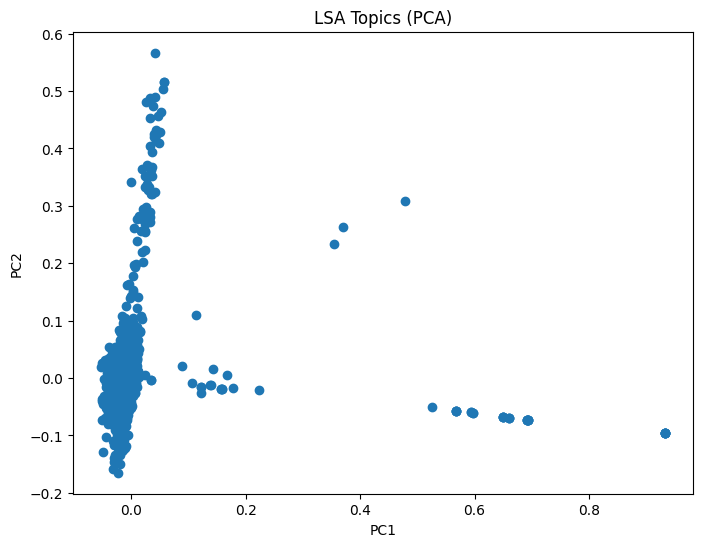

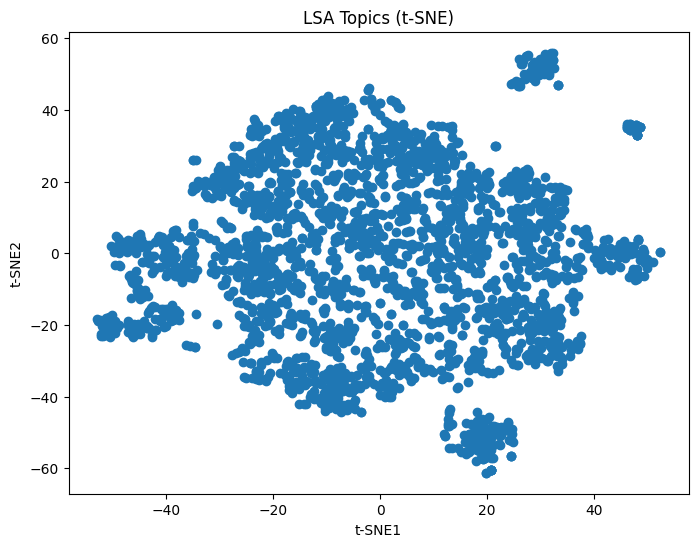

       Topic  Semantic_Coherence   Word_1   Word_2   Word_3   Word_4  \
0       time            0.350579    could     upon    would    great   
1         iv            0.300037  chapter      iii       ii     viii   
2  described            0.243164   author  country  account   voyage   
3        one            0.233763   author     foot    three  hundred   
4       time            0.264025    great     king    court   person   
5       part            0.319604     part       ii      iii       iv   
6      least            0.272037     foot  country    could     high   
7       made            0.344717     part    great    could  several   
8       took            0.220614     made    could  majesty  country   
9        two            0.359821  country      one     came     took   

      Word_5      Word_6     Word_7   Word_8  ...  Weight_1  Weight_2  \
0        one         two    country     time  ...  0.193422  0.185313   
1         iv      author        vii       vi  ...  0.944009  

In [4]:
pdf_path = "./books/Gulliver's_Travels.pdf" 
Gulliver_topics = process_pdf_for_topics(pdf_path, n_topics=10)
print(Gulliver_topics)

# Alice's Adventures in Wonderland by Lewis Carroll

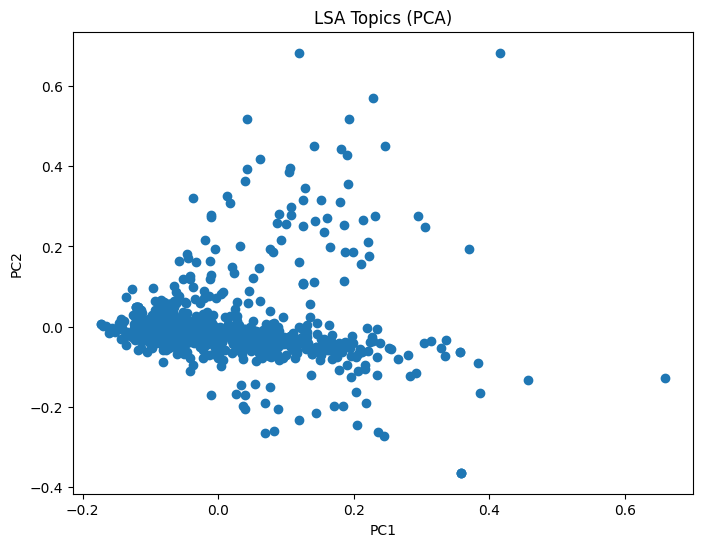

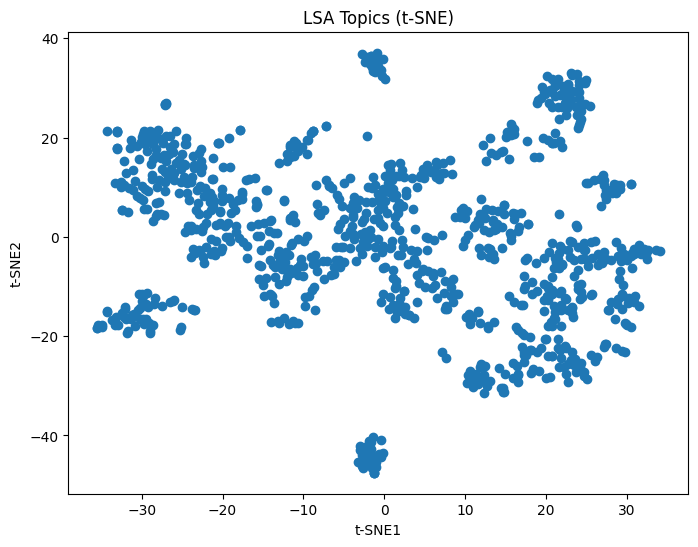

     Topic  Semantic_Coherence       Word_1  Word_2   Word_3   Word_4  \
0  thought            0.246696         said   alice     know     king   
1     king            0.139382         said   march     hare   turtle   
2   turtle            0.125202       turtle    mock  gryphon  lobster   
3   little            0.108206        march    hare   turtle     went   
4    white            0.228854        queen    king     head  shouted   
5     wish            0.143058           oh    dear    dinah      cat   
6    thing            0.113551         know  hatter  chapter     king   
7    could            0.287812          cat   would     well     like   
8    could            0.189825      chapter   would      cat       ii   
9      one            0.043003  caterpillar   dance  gryphon     join   

    Word_5    Word_6   Word_7       Word_8  ...  Weight_1  Weight_2  Weight_3  \
0     like    turtle     mock       little  ...  0.564464  0.390179  0.156580   
1     mock      king   hatter  cat

In [5]:
pdf_path = "./books/AliceinWonderland.pdf" 
AliceinWonderland_topics = process_pdf_for_topics(pdf_path, n_topics=10)
print(AliceinWonderland_topics)

# A Christmas Carol in Prose; Being a Ghost Story of Christmas by Charles Dickens

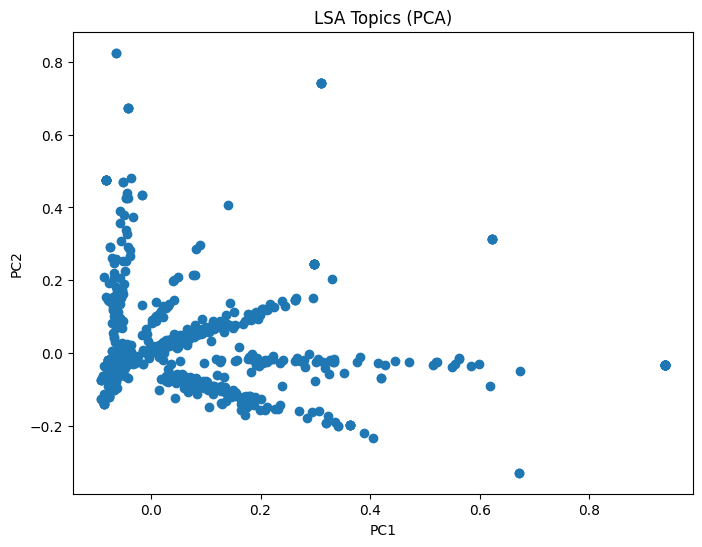

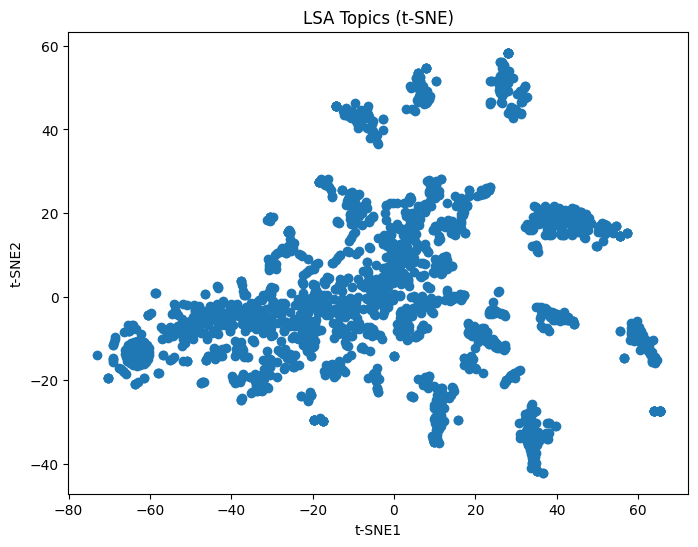

   Topic  Semantic_Coherence     Word_1     Word_2     Word_3  Word_4 Word_5  \
0   know            0.115930       said    scrooge      ghost   cried  asked   
1   know            0.170317     spirit      cried  christmas   ghost  merry   
2  uncle            0.148771      cried    scrooge      asked    fred  uncle   
3   good            0.222903  christmas      merry       know     day  ghost   
4  woman            0.231048      cried       said       know  nephew    bob   
5    say            0.202697       know    scrooge      asked     man   dead   
6    day            0.221663      merry  christmas       know  spirit  cried   
7   know            0.162618      ghost  exclaimed    replied   asked   know   
8   look            0.202257       come        see    parlour  nephew    yes   
9   kind            0.201539         oh        man   glorious      ha  never   

     Word_6    Word_7   Word_8  ...  Weight_1  Weight_2  Weight_3  Weight_4  \
0    nephew    spirit     hand  ...  0.7

In [6]:
pdf_path = "./books/AChristmasCarolinProse.pdf" 
AChristmasCarolinProse_topics = process_pdf_for_topics(pdf_path, n_topics=10)
print(AChristmasCarolinProse_topics)

# Frankenstein; Or, The Modern Prometheus by Mary Wollstonecraft Shelley

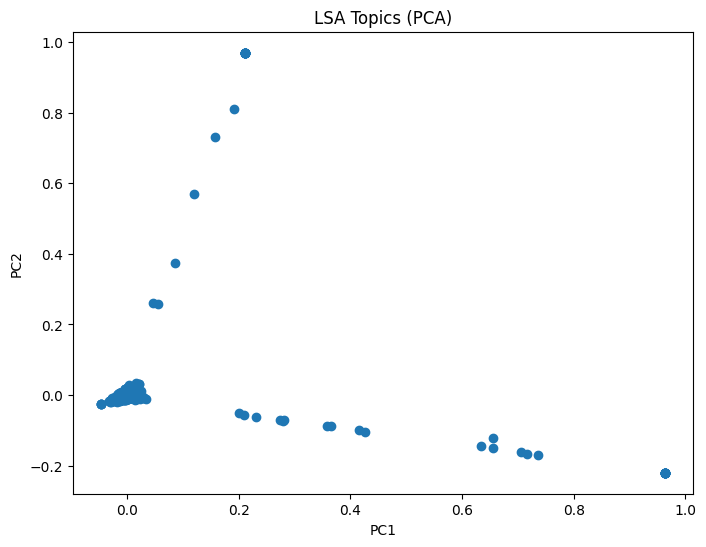

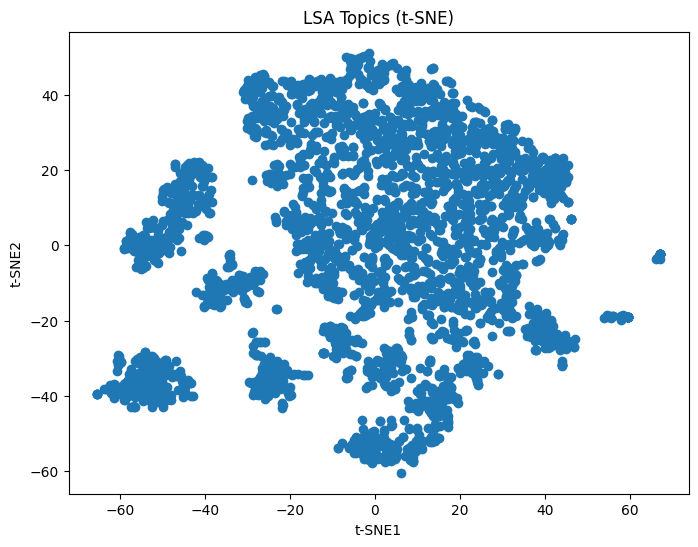

     Topic  Semantic_Coherence Word_1   Word_2        Word_3     Word_4  \
0    could            0.410750  could      one         would        yet   
1    agony            0.097242     oh      ala  frankenstein       fear   
2   really            0.093078    ala     said        victor   contrast   
3  nothing            0.299323  could  nothing         human      doubt   
4    shall            0.287187  shall      yet          said      would   
5   father            0.310073    man     said           old  elizabeth   
6      one            0.254464    man      old         shall        yet   
7     soon            0.230658  shall      god           die      great   
8     even            0.313842    god    great          good     friend   
9     hope            0.252620    one      yet          dear     friend   

     Word_5   Word_6   Word_7   Word_8  ...  Weight_1  Weight_2  Weight_3  \
0       man      day   friend   father  ...  0.233547  0.189014  0.167178   
1  abhorred     said

In [7]:
pdf_path = "./books/Frankenstein.pdf" 
Frankenstein_topics = process_pdf_for_topics(pdf_path, n_topics=10)
print(Frankenstein_topics)

# The Time Machine by H. G. Wells

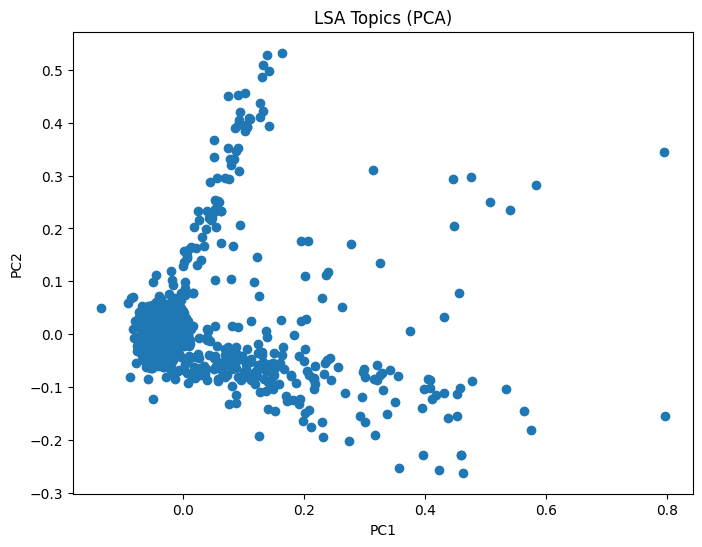

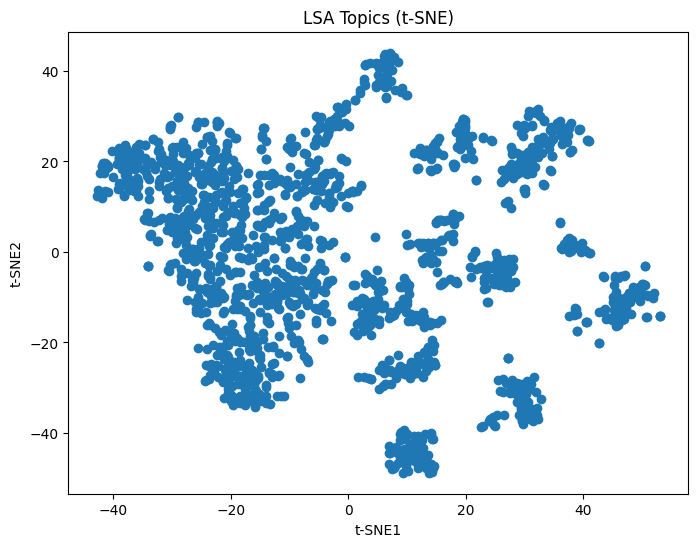

    Topic  Semantic_Coherence   Word_1     Word_2     Word_3        Word_4  \
0     one            0.208501     time  traveller       said       machine   
1   asked            0.195578     time  traveller       said       machine   
2     one            0.276136     said        man    medical  psychologist   
3   could            0.382083    could        see      thing         think   
4  looked            0.352698   looked       came    thought         could   
5  seemed            0.114365   looked      weena     little         round   
6    time            0.224937    thing        one  traveller           saw   
7     put            0.374348     hand        one      could        looked   
8    know            0.091314    thing    machine      weena        looked   
9     way            0.355820  thought     little     people         weena   

       Word_5  Word_6        Word_7  Word_8  ...  Weight_1  Weight_2  \
0        came     one          hand    upon  ...  0.598690  0.353095 

In [8]:
pdf_path = "./books/TheTimeMachine.pdf" 
TheTimeMachine_topics = process_pdf_for_topics(pdf_path, n_topics=10)
print(TheTimeMachine_topics)

# The Art of War by active 6th century B.C. Sunzi

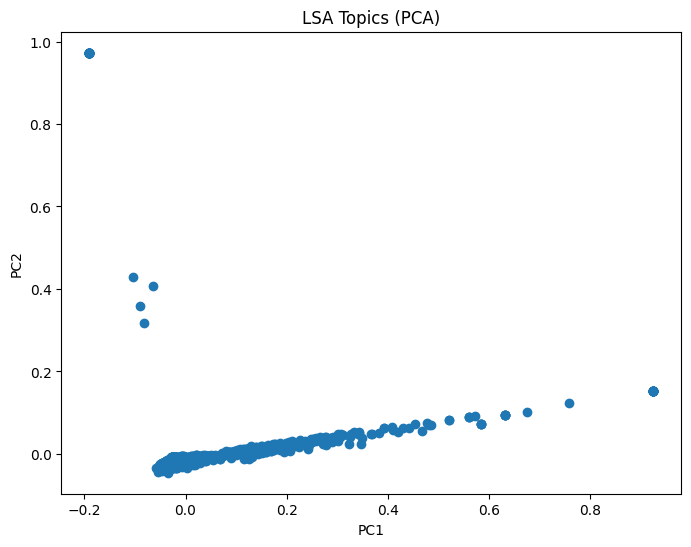

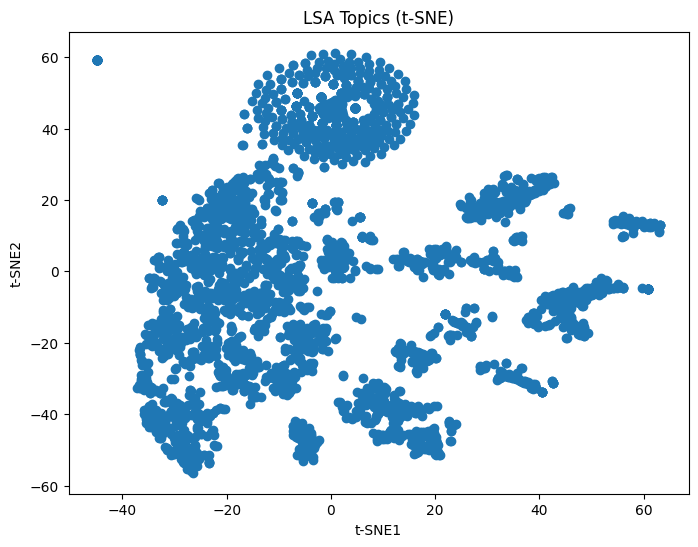

   Topic  Semantic_Coherence   Word_1   Word_2    Word_3   Word_4 Word_5  \
0    say            0.149935       ch       wu       see      tzŭ    sun   
1     cf            0.096420       cf      men  besieged     town  enemy   
2     te            0.091433       ch       cf       see      han     te   
3    iii            0.222071      see  chapter        ii     xiii     ix   
4   king            0.191635      tzŭ      sun        wu  chapter    see   
5    iii            0.127329  chapter   energy        xi       iv     ch   
6  chang            0.119602     note       ao        yu     kung  chang   
7    one            0.224912     note    enemy    attack       wu   yüeh   
8    way            0.134087   ground       ao       one     army   kung   
9     lu            0.200188       wu       ao      kung   ground     ho   

  Word_6   Word_7   Word_8  ...  Weight_1  Weight_2  Weight_3  Weight_4  \
0    han      uan       ao  ...  0.903395  0.167133  0.144448  0.133128   
1   yüeh     

In [9]:
pdf_path = "./books/TheArtofWar.pdf" 
TheArtofWar_topics = process_pdf_for_topics(pdf_path, n_topics=10)
print(TheArtofWar_topics)

# A Pickle for the Knowing Ones by Timothy Dexter

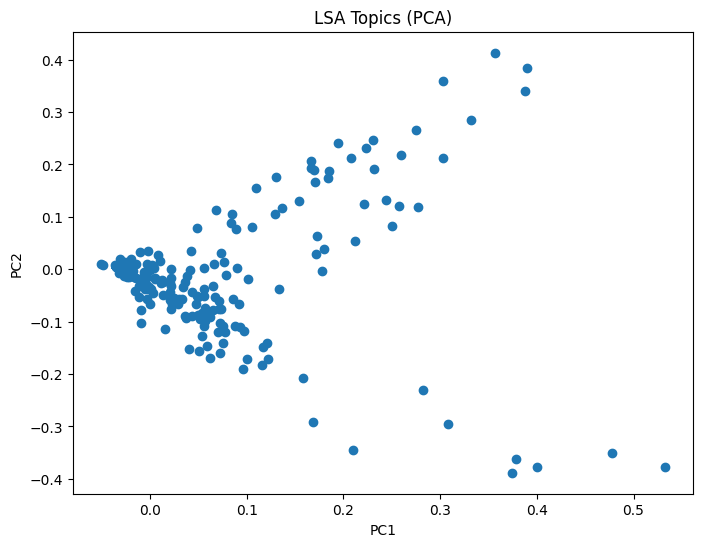

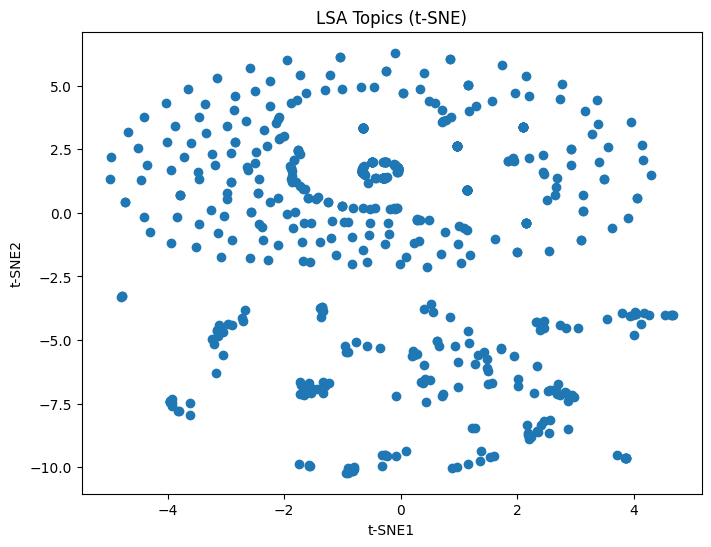

     Topic  Semantic_Coherence       Word_1   Word_2       Word_3  \
0      man            0.199440       dexter     lord          one   
1      ted            0.179889       dexter     lord      timothy   
2     soul            0.209522         soul    great       bubble   
3    would            0.148542         fame      thy         name   
4     name            0.148812      edition      thy          one   
5     hear            0.253626       wonder      son      believe   
6   admire            0.283594          see   wonder         hear   
7     hear            0.093728        house   wonder  newburyport   
8  believe            0.201161          may     poet       wonder   
9   street            0.084956  newburyport  marquis         high   

         Word_4  Word_5     Word_6   Word_7   Word_8  ...  Weight_1  Weight_2  \
0          good     man      great  timothy      say  ...  0.412799  0.308637   
1  illustration    name        dog      ted  celebra  ...  0.470283  0.382212 

In [10]:
pdf_path = "./books/APicklefortheKnowingOnes.pdf" 
APicklefortheKnowingOnes_topics = process_pdf_for_topics(pdf_path, n_topics=10)
print(APicklefortheKnowingOnes_topics)

# Heart of Darkness by Joseph Conrad

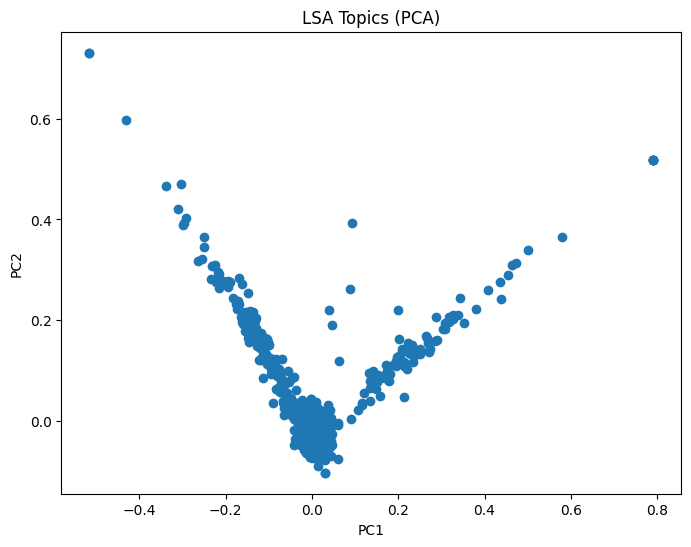

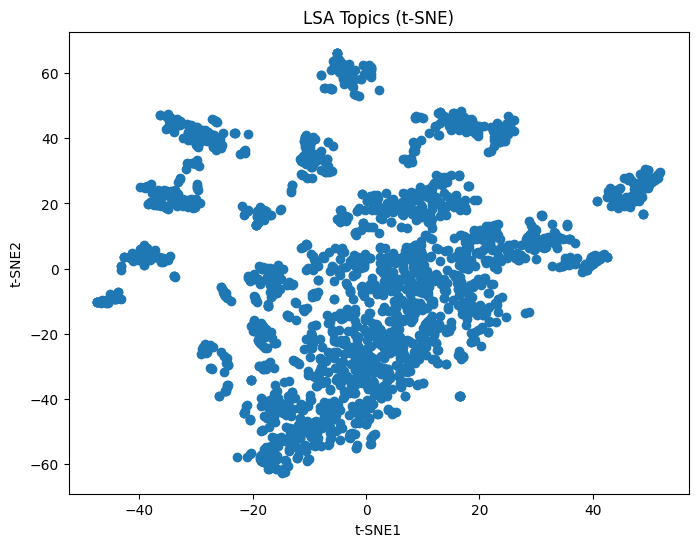

     Topic  Semantic_Coherence Word_1 Word_2  Word_3  Word_4   Word_5  Word_6  \
0    could            0.350008   said   know     see   kurtz      man     one   
1     know            0.364186   know    one     man   never   seemed   cried   
2     want            0.279126   said   know      oh    well     keep   cried   
3       oh            0.277070     oh    say   heard     yes  manager    time   
4     know            0.303353    see     oh   could   never     said    tell   
5    going            0.381021   well  think    time  absurd    going   never   
6      say            0.343000    man   like   never   great   looked  simple   
7  thought            0.181673  kurtz   well    time     man    voice   heard   
8     like            0.292226  voice    yes  little    long   looked    like   
9     well            0.153455    one  kurtz   voice     man    could    well   

      Word_7     Word_8  ...  Weight_1  Weight_2  Weight_3  Weight_4  \
0      could      would  ...  0.3847

In [12]:
pdf_path = "./books/HeartofDarkness.pdf" 
HeartofDarkness_topics = process_pdf_for_topics(pdf_path, n_topics=10)
print(HeartofDarkness_topics)

# life on the mississippi

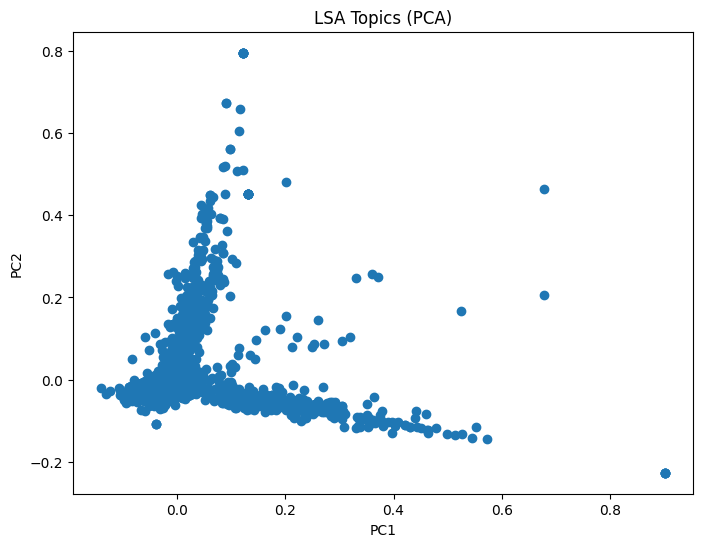

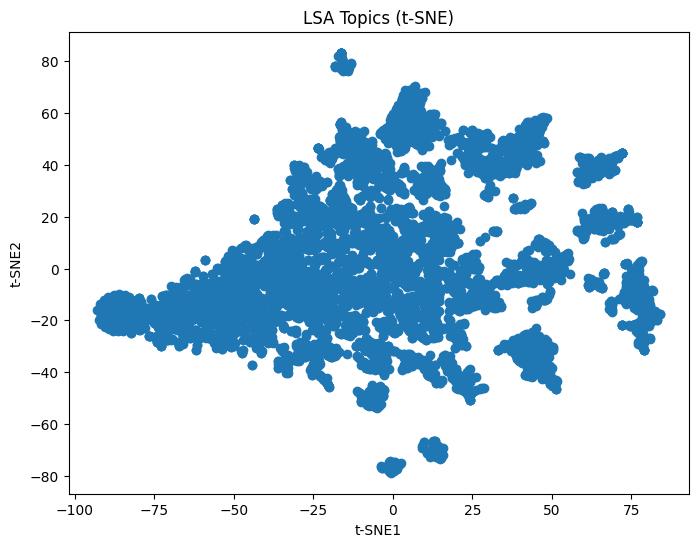

   Topic  Semantic_Coherence   Word_1 Word_2 Word_3 Word_4 Word_5 Word_6  \
0  could            0.378039     said    one  would   time  river    say   
1   know            0.373283     said   know    say  would    sir   done   
2    say            0.275581      say   know    sir   tell   well   davy   
3   tell            0.168163     know    sir  river    got   boat   tell   
4  could            0.273538      sir   time  would  right   come    get   
5    man            0.240759      one    sir   said  three    two    day   
6   take            0.411436    would    one  could     go    man   take   
7   ever            0.388365     time    one  never    day    saw   know   
8     go            0.403642      see  going   tell    one   come     go   
9   time            0.254979  chapter  would    man    new    day     go   

    Word_7   Word_8  ...  Weight_1  Weight_2  Weight_3  Weight_4  Weight_5  \
0     know    could  ...  0.320103  0.301504  0.205974  0.190022  0.188031   
1  noth

In [13]:
pdf_path = "./books/lifeonthemississippi.pdf" 
lifeonthemississippi_topics = process_pdf_for_topics(pdf_path, n_topics=10)
print(lifeonthemississippi_topics)

Total A star time: 3.236769 seconds


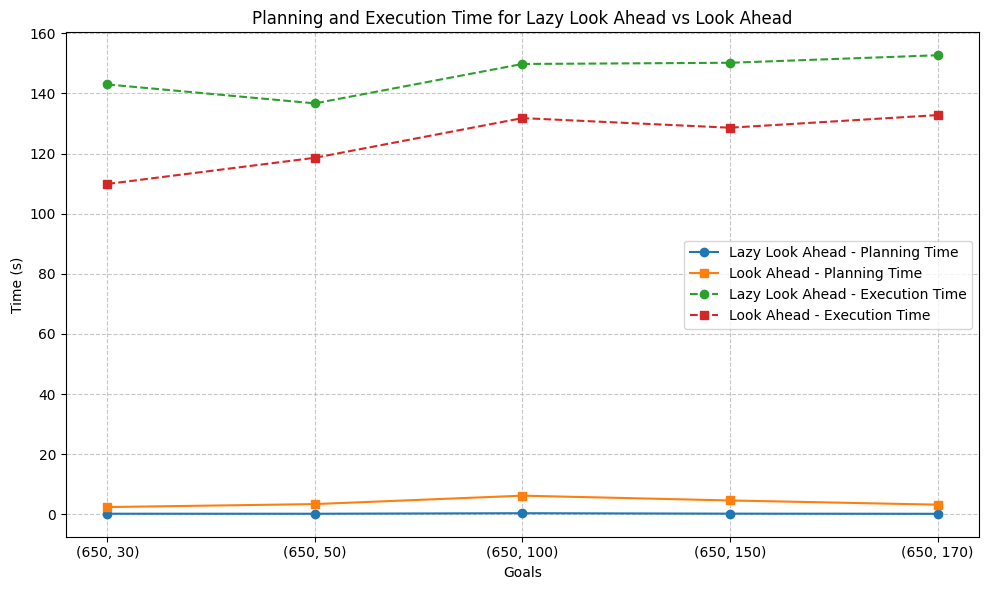

: 

In [ ]:
import matplotlib.pyplot as plt

# Data from the table
goals = ['(650, 30)', '(650, 50)', '(650, 100)', '(650, 150)', '(650, 170)']
lazy_look_ahead_planning = [0.217, 0.210, 0.386, 0.240, 0.192]
lazy_look_ahead_execution = [143.001, 136.70, 149.801, 150.20, 152.702]
look_ahead_planning = [2.43, 3.42, 6.22, 4.63, 3.23]
look_ahead_execution = [109.90, 118.60, 131.80, 128.60, 132.80]

# Plotting
plt.figure(figsize=(10, 6))

# Planning Time
plt.plot(goals, lazy_look_ahead_planning, marker='o', label='Lazy Look Ahead - Planning Time')
plt.plot(goals, look_ahead_planning, marker='s', label='Look Ahead - Planning Time')

# Execution Time
plt.plot(goals, lazy_look_ahead_execution, marker='o', linestyle='--', label='Lazy Look Ahead - Execution Time')
plt.plot(goals, look_ahead_execution, marker='s', linestyle='--', label='Look Ahead - Execution Time')

# Graph details
plt.title('Planning and Execution Time for Lazy Look Ahead vs Look Ahead')
plt.xlabel('Goals')
plt.ylabel('Time (s)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()
